# This is the in situ and SSS collocation code. 

This code is easily adaptable to other in situ datasets and other types of orbital data.
Basic description:
1. PyResample swath definition and resampling capabilites are used to quickly determine if the orbital data contains any data that might collocate with the in situ data
1. SciPy kd_tree search to quickly find the nearest in situ / satellite matchup


In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import cartopy.crs as ccrs
from pyresample.geometry import AreaDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition, area_def2basemap
from pyresample.kd_tree import resample_nearest
from scipy import spatial
sys.path.append('./subroutines/')
from read_routines import read_usv, get_filelist_l2p,get_orbital_data_l2p
import warnings
warnings.simplefilter('ignore') # filter some warning messages

# Define a function to read in insitu data
- Read in the Saildrone USV file either from a local disc or using OpenDAP.
- add room to write collocated data to in situ dataset

## explore the in situ data and quickly plot using cartopy


In [2]:
adir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/'
for iusv in range(8,12):
    ds_usv,usvname=read_usv(adir,iusv)
    #ds_usv,usvname = read_usv(iusv)
    print(usvname)
    #plot cruise SSS with coastlines
    ax = plt.axes(projection=ccrs.PlateCarree())
    #ds_usv = ds_usv.where(np.isfinite(ds_usv.lon))
    cs1 = ax.scatter(ds_usv.lon, ds_usv.lat, s=3.0, c=ds_usv.SAL_MEAN, edgecolor='none', cmap='jet',vmin=33,vmax=34.35)
    ax.coastlines()
    x1,x2,y1,y2 = ds_usv.lon.min().data-2,ds_usv.lon.max().data+2,ds_usv.lat.min().data-2,ds_usv.lat.max().data+2
    ax.set_xlim(x1,x2)
    ax.set_ylim(y1,y2)
    ax.set_xticks(np.arange(x1,x2,4))
    ax.set_yticks(np.arange(y1,y2,5))
    cax = plt.colorbar(cs1)
    cax.set_label('Salinity (psu)')
    fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/'+usvname+'_location.png'
    plt.savefig(fig_fname, transparent=False, format='png')
    plt.clf()

FILEIN: C:/Users/gentemann/Google Drive/public/2019_saildrone/arctic_2019_sd1037-NRT-1_min-v1.nc
arctic2019_1037
FILEIN: C:/Users/gentemann/Google Drive/public/2019_saildrone/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1440_minutes-v1.1564857794963.nc
antarctic2019
FILEIN: C:/Users/gentemann/Google Drive/public/2019_saildrone/wcoast_2018_sd1024-ALL-1_min-v1.nc
wcoast1025
FILEIN: C:/Users/gentemann/Google Drive/public/2019_saildrone/wcoast_2018_sd1025-ALL-1_min-v1.nc
wcoast1026


<Figure size 432x288 with 0 Axes>

## An example showing how the using matplotlib maps orbital data quickly and easily



FILEIN: C:/Users/gentemann/Google Drive/public/2019_saildrone/wcoast_2018_sd1024-ALL-1_min-v1.nc


(25.0, 40.0)

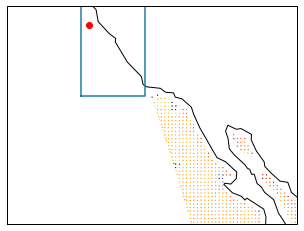

In [3]:
adir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/'
ds_usv,usvname=read_usv(adir,10)
file = 'F:/data/sat_data/smap/SSS/L2/RSS/V3/40km/2018/115/RSS_SMAP_SSS_L2C_40km_r17250_20180425T004136_2018115_FNL_V03.0.nc'
ds = xr.open_dataset(file)
ds.close()
x = ds.cellon.data
y = ds.cellat.data
z = ds.sss_smap.data
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(x, y, s=1.0, c=z, edgecolor='none', cmap='jet')
minlon,maxlon,minlat,maxlat = ds_usv.lon.min().data,ds_usv.lon.max().data,ds_usv.lat.min().data,ds_usv.lat.max().data
ax.plot([minlon,maxlon,maxlon,minlon,minlon],[minlat,minlat,maxlat,maxlat,minlat])
#ax.plot(ds.cellon[jj,ii],ds.cellat[jj,ii,0],'b*')
ax.plot(ds_usv.lon[1000],ds_usv.lat[1000],'ro')
ax.coastlines()
ax.set_xlim(-130,-110)
ax.set_ylim(25,40)

## But you can't search off of a scatter plot, so let's use pyresample to quickly project the orbit

In [4]:
ds

<xarray.Dataset>
Dimensions:            (look: 2, polarization_2: 2, polarization_3: 3, polarization_4: 4, xdim_grid: 1560, ydim_grid: 720)
Coordinates:
    time               (ydim_grid, xdim_grid, look) datetime64[ns] ...
    cellat             (ydim_grid, xdim_grid, look) float32 nan nan ... nan nan
    cellon             (ydim_grid, xdim_grid, look) float32 nan nan ... nan nan
Dimensions without coordinates: look, polarization_2, polarization_3, polarization_4, xdim_grid, ydim_grid
Data variables:
    gland              (ydim_grid, xdim_grid, look) float32 ...
    gice               (ydim_grid, xdim_grid) float32 ...
    surtep             (ydim_grid, xdim_grid) float32 ...
    winspd             (ydim_grid, xdim_grid) float32 ...
    sss_ref            (ydim_grid, xdim_grid) float32 ...
    tran               (ydim_grid, xdim_grid) float32 ...
    tbup               (ydim_grid, xdim_grid) float32 ...
    tbdw               (ydim_grid, xdim_grid) float32 ...
    windir             (ydim_grid, xdim_grid) float32 ...
    rain               (ydim_grid, xdim_grid) float32 ...
    solar_flux         (ydim_grid, xdim_grid) float32 ...
    temp_ant           (ydim_grid, xdim_grid, look, polarization_2) float32 ...
    zang               (ydim_grid, xdim_grid, look) float32 ...
    alpha              (ydim_grid, xdim_grid, look) float32 ...
    eaa                (ydim_grid, xdim_grid, look) float32 ...
    eia                (ydim_grid, xdim_grid, look) float32 ...
    pra                (ydim_grid, xdim_grid, look) float32 ...
    sunglt             (ydim_grid, xdim_grid, look) float32 ...
    monglt             (ydim_grid, xdim_grid, look) float32 ...
    gallat             (ydim_grid, xdim_grid, look) float32 ...
    gallon             (ydim_grid, xdim_grid, look) float32 ...
    sun_beta           (ydim_grid, xdim_grid, look) float32 ...
    sun_alpha          (ydim_grid, xdim_grid, look) float32 ...
    ta_ant_filtered    (ydim_grid, xdim_grid, look, polarization_4) float32 ...
    dtemp_ant          (ydim_grid, xdim_grid, look, polarization_2) float32 ...
    ta_sun_dir         (ydim_grid, xdim_grid, look, polarization_3) float32 ...
    ta_sun_ref         (ydim_grid, xdim_grid, look, polarization_3) float32 ...
    ta_gal_dir         (ydim_grid, xdim_grid, look, polarization_3) float32 ...
    ta_gal_ref         (ydim_grid, xdim_grid, look, polarization_3) float32 ...
    ta_ant_calibrated  (ydim_grid, xdim_grid, look, polarization_4) float32 ...
    ta_earth           (ydim_grid, xdim_grid, look, polarization_4) float32 ...
    tb_toi             (ydim_grid, xdim_grid, look, polarization_4) float32 ...
    tb_toa             (ydim_grid, xdim_grid, look, polarization_4) float32 ...
    tb_toa_lc          (ydim_grid, xdim_grid, look, polarization_4) float32 ...
    tb_sur             (ydim_grid, xdim_grid, look, polarization_4) float32 ...
    tb_sur0            (ydim_grid, xdim_grid, look, polarization_4) float32 ...
    sss_smap           (ydim_grid, xdim_grid, look) float32 nan nan ... nan nan
    iqc_flag           (ydim_grid, xdim_grid, look) int32 ...
    tb_consistency     (ydim_grid, xdim_grid, look) float32 ...
    ta_ant_exp         (ydim_grid, xdim_grid, look, polarization_4) float32 ...
    tb_sur0_exp        (ydim_grid, xdim_grid, look, polarization_4) float32 ...
    pratot_exp         (ydim_grid, xdim_grid, look) float32 ...
Attributes:
    Conventions:                                        CF-1.6, ACDD-1.3
    title:                                              SMAP ocean surface sa...
    version:                                            V3.0 validated releas...
    processing_level:                                   L2C
    level:                                              Level 2: swath observ...
    resolution:                                         Spatial resolution: 40km
    history:                                            created by T. Meissner
    date_created:                              

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


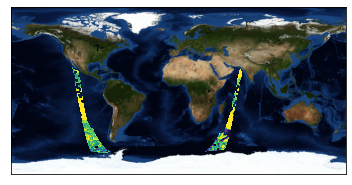

In [5]:
area_def = load_area('areas.cfg', 'pc_world')
rlon=np.arange(-180,180,.1)
rlat=np.arange(90,-90,-.1)
file = 'F:/data/sat_data/smap/SSS/L2/RSS/V4/SCI/2018/115/RSS_SMAP_SSS_L2C_r17250_20180425T004136_2018115_FNL_V04.0.nc'
#file = 'F:/data/sat_data/smap/SSS/L2/JPL/V4.2/2018/020/SMAP_L2B_SSS_15866_20180120T093138_R16010_V4.2.h5'
ds = xr.open_dataset(file)
ds.close()
ds = ds.isel(look=0)
x = (np.mod(ds.cellon+180,360)-180).data 
y = ds.cellat.data 
z = ds.sss_smap.data 
lons,lats,data = x,y,z 
swath_def = SwathDefinition(lons, lats)
result = resample_nearest(swath_def, data, area_def, radius_of_influence=20000, fill_value=None)
save_quicklook('C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/sss2.png', area_def, result, num_meridians=0, num_parallels=0, label='Salinity (psu)')
#now plot on basemap
bmap = area_def2basemap(area_def)
bmng = bmap.bluemarble()
col = bmap.imshow(result, origin='upper',vmin=32,vmax=35)

## First let's figure out what orbital files actually have data in our area of interest.  To do this, use the pyresample software

- read in the in situ data
- calculate the in situ min/max dates to know what files to check

Now we have our time of interest

- loop through the satellite data
- calculate the in situ min/max lat/lon on the same day to define a small box of interest
- use pyresample to map the data onto a predefined 0.1 deg resolution spatial grid
- subset the gridded map to the area of interest
- see if there is any valid data in that area
- if there is any valid data, go to next step

## Use the fast search kdtree which is part of pyresample software, but I think maybe comes originally from sci-kit-learn.

- read in the in situ data
- read in a single orbit of satellite data
- kdtree can't handle it when lat/lon are set to nan.  I frankly have no idea why there is orbital data for both the JPL and RSS products that have nan for the geolocation.  That isn't normal.  But, okay, let's deal with it.  
- stack the dataset scanline and cell positions into a new variable 'z'
- drop all variables from the dataset when the longitude is nan
- set up the tree
- loop through the orbital data
- only save a match if it is less than 0.25 deg distance AND time is less than any previous match
- save the satellite indices & some basic data onto the USV grid




In [ ]:
#effort to combine the finding & collocating code
#intialize grid
adir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/'
for iusv in range(4,5):
    area_def = load_area('areas.cfg', 'pc_world')
    rlon=np.arange(-180,180,.1)
    rlat=np.arange(90,-90,-.1)

    for isat in range(0,1):

        ds_usv,name_usv=read_usv(adir,iusv)

        if isat==0:
            fileout = 'F:/data/cruise_data/saildrone/sss_collocations/'+name_usv+'rssv4_filesave2.nc'
        if isat==1:
            fileout = 'F:/data/cruise_data/saildrone/sss_collocations/'+name_usv+'jplv4.2_filesave2.nc'   

        if path.exists(fileout):
            continue

        #search usv data
        minday,maxday = ds_usv.time[0],ds_usv.time[-1]
        usv_day = minday
        print(minday.data,maxday.data)
        while usv_day<=maxday:
            ds_day = ds_usv.sel(time=slice(usv_day-np.timedelta64(1,'D'),usv_day+np.timedelta64(1,'D')))
            ilen = ds_day.time.size
            if ilen<1:   #don't run on days without any data
                continue
            minlon,maxlon,minlat,maxlat = ds_day.lon.min().data,ds_day.lon.max().data,ds_day.lat.min().data,ds_day.lat.max().data
            filelist = get_filelist_l2p(isat, usv_day)
            x,y,z = [],[],[]
            for file in filelist:
                ds = xr.open_dataset(file)
                ds.close()  
                if isat==0:  #change RSS data to conform with JPL definitions
                    ds = ds.isel(look=0)
                    ds = ds.rename({'iqc_flag':'quality_flag','cellon':'lon','cellat':'lat','sss_smap':'smap_sss','ydim_grid':'phony_dim_0','xdim_grid':'phony_dim_1'})
                    ds['lon']=np.mod(ds.lon+180,360)-180  
                if isat==1:  #change RSS data to conform with JPL definitions
                    ds = ds.rename({'row_time':'time'})

#first do a quick check using resample to project the orbit onto a grid 
#and quickly see if there is any data in the cruise area on that day
#if there is, then continue to collocation

                x = ds['lon'].fillna(-89).data 
                y = ds['lat'].fillna(-89).data 
                z = ds['smap_sss'].data 
                lons,lats,data = x,y,z 
                swath_def = SwathDefinition(lons, lats)
                result1 = resample_nearest(swath_def, data, area_def, radius_of_influence=20000, fill_value=None)
                da = xr.DataArray(result1,name='sss',coords={'lat':rlat,'lon':rlon},dims=('lat','lon'))
                subset = da.sel(lat = slice(maxlat,minlat),lon=slice(minlon,maxlon))
                num_obs = np.isfinite(subset).sum()
                if num_obs<1:  #no collocations so go to next orbit
                    continue

                #stack xarray dataset then drop lon == nan
                ds2 = ds.stack(z=('phony_dim_0', 'phony_dim_1')).reset_index('z')
                #drop nan
                ds_drop = ds2.where(np.isfinite(ds2.lon),drop=True)
                lats = ds_drop.lat.data
                lons = ds_drop.lon.data
                inputdata = list(zip(lons.ravel(), lats.ravel()))
                tree = spatial.KDTree(inputdata)
                orbit_time = ds.time.max().data-np.timedelta64(1,'D')
                orbit_time2 = ds.time.max().data+np.timedelta64(1,'D')    
         #       usv_subset = ds_usv.sel(time=slice(orbit_time,orbit_time2))
                ilen = ds_usv.time.size
                for iusv_index in range(ilen):
                    if (ds_usv.time[iusv_index]<orbit_time) or (ds_usv.time[iusv_index]>orbit_time2):
                        continue
                    pts = np.array([ds_usv.lon[iusv_index], ds_usv.lat[iusv_index]])
            #        pts = np.array([ds_usv.lon[iusv]+360, ds_usv.lat[iusv]])
                    tree.query(pts,k=1)
                    i = tree.query(pts)[1]
                    rdist = tree.query(pts)[0]
                    #don't use matchups more than 25 km away
                    if rdist>.25:
                        continue
                    #use .where to find the original indices of the matched data point
                    #find by matching sss and lat, just randomly chosen variables, you could use any
                    result = np.where((ds.smap_sss == ds_drop.smap_sss[i].data) & (ds.lat == ds_drop.lat[i].data))
                    listOfCoordinates = list(zip(result[0], result[1]))
                    if len(listOfCoordinates)==0:
                        continue
                    ii, jj = listOfCoordinates[0][0],listOfCoordinates[0][1]
                    if isat==0:
                        deltaTa = ((ds_usv.time[iusv_index]-ds.time[ii,jj]).data)/ np.timedelta64(1,'m')
                    if isat==1:
                        deltaTa = ((ds_usv.time[iusv_index]-ds.time[ii]).data)/ np.timedelta64(1,'m')
                    if np.abs(deltaTa)<np.abs(ds_usv.deltaT[iusv_index].data):
                        ds_usv.deltaT[iusv_index]=deltaTa
                        ds_usv.smap_SSS[iusv_index]=ds.smap_sss[ii,jj]
                        ds_usv.smap_iqc_flag[iusv_index]=ds.quality_flag[ii,jj]
                        ds_usv.smap_name[iusv_index]=file
                        ds_usv.smap_dist[iusv_index]=rdist
                        ds_usv.smap_ydim[iusv_index]=ii
                        ds_usv.smap_xdim[iusv_index]=jj
            usv_day += np.timedelta64(1,'D')
        ds_usv.to_netcdf(fileout)




# A larger STD that isn't reflective of uncertainty in the observation
The collocation above will result in multiple USV data points matched with a single satellite
observation.    The USV is sampling every 1 min and approximately few meters, while the satellite
is an average over a footprint that is interpolated onto a daily mean map.  While calculating the mean would results in a valid mean, the STD would be higher and consist of a component that reflects the uncertainty of the USV and the satellite and a component that reflects the natural variability in the region that is sampled by the USV

Below we use the 'nearest' collocation results to identify when multiple USV data are collcated to
a single satellite observation.
This code goes through the data and creates averages of the USV data that match the single CCMP collocated value.


In [ ]:
for isat in range(2):
    if isat==0:
        file = 'F:/data/cruise_data/saildrone/sat_collocations/rss40km_usv2.nc'
        fileout = 'F:/data/cruise_data/saildrone/sat_collocations/rss40km_usv2_norepeats.nc'
    if isat==1:
        file = 'F:/data/cruise_data/saildrone/sat_collocations/jplv42_usv2.nc'   
        fileout = 'F:/data/cruise_data/saildrone/sat_collocations/jplv42_usv2_norepeats.nc'   
    ds_usv=xr.open_dataset(file)
    ds_usv.close()
    ds_usv = ds_usv.where(ds_usv.smap_SSS<10000,np.nan)
    ilen,index = ds_usv.dims['time'],0
    ds_tem = ds_usv.copy(deep=True)
    duu, duu2, duv1, duv2, dlat, dlon, dut = [],[],[],[],[],[],np.empty((),dtype='datetime64')
    index=0
    while index <= ilen-2:
        index += 1
        if np.isnan(ds_usv.smap_SSS[index]):
            continue
        if np.isnan(ds_usv.smap_xdim[index]):
            continue
        result = np.where((ds_usv.smap_xdim == ds_tem.smap_xdim[index].data) & (ds_usv.smap_ydim == ds_tem.smap_ydim[index].data))       
        duu=np.append(duu,ds_usv.smap_SSS[result[0][0]].data)
        duu2=np.append(duu2,ds_usv.smap_iqc_flag[result[0][0]].data)
        duv1=np.append(duv1,ds_usv.SAL_MEAN[result].mean().data)
        dlat=np.append(dlat,ds_usv.lat[result].mean().data)
        dlon=np.append(dlon,ds_usv.lon[result].mean().data)
        dut=np.append(dut,ds_usv.time[result].mean().data)
        ds_usv.smap_SSS[result]=np.nan
    dut2 = dut[1:]  #remove first data point which is a repeat from what array defined       
    ds_new=xr.Dataset(data_vars={'smap_SSS': ('time',duu),'smap_iqc_flag': ('time',duu2),
                                 'SAL_MEAN':('time',duv1),
                                 'lon': ('time',dlon),
                                 'lat': ('time',dlat)},
                      coords={'time':dut2})
    ds_new.to_netcdf(fileout)



# Now look at bias/std & plot 

In [ ]:
files =['F:/data/cruise_data/saildrone/sat_collocations/rss40km_usv2_norepeats.nc',
        'F:/data/cruise_data/saildrone/sat_collocations/jplv42_usv2_norepeats.nc',
        'F:/data/cruise_data/saildrone/sat_collocations/rss40km_usv2.nc',
        'F:/data/cruise_data/saildrone/sat_collocations/jplv42_usv2.nc']
flabel=['RSS','JPL','RSS','JPL']
for isat in range(4):
    file = files[isat]
    ds_usv=xr.open_dataset(file)
    ds_usv = ds_usv.where(ds_usv.smap_SSS<10000,np.nan)
    ds_usv = ds_usv.where(ds_usv.smap_iqc_flag<9400,np.nan)
    if isat==1 or isat==3:
        ds_usv = ds_usv.where(ds_usv.smap_iqc_flag<1,np.nan)
    tem=ds_usv.smap_SSS-ds_usv.SAL_MEAN
    tem = tem.where(np.isfinite(tem),drop=True)
    print(flabel[isat],tem.mean().data,tem.std().data,tem.size)


# just playing around & plotting stuff

In [ ]:
#ds_usv.time.plot()
#subset = ds_usv.sel(time=slice('2018-01-01','2019-01-01'))
#print(subset.time.dt.dayofyear)
#print(ds_usv.time[0:100].dt.year,ds_usv.time[0:100].dt.dayofyear)
#ds_usv.where(ds_usv['lon']>-180)
adir,iusv = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/',11
ds_usv,name=read_usv(adir,iusv)
print(ds_usv.time.min().data,ds_usv.time.max().data)
print(ds_usv.time.min().dt.dayofyear.data,ds_usv.time.max().dt.dayofyear.data)
ds_usv


In [ ]:
isat=1
flist = get_filelist_l2p(isat, ds_usv.time[0])
flist
print(flist[0])
xlat,xlon,sat_time,var_data,sat_qc = get_orbital_data_l2p(isat,flist[0])
isat=0
flist = get_filelist_l2p(isat, ds_usv.time[0])
flist
#xlat,xlon,sat_time,var_data,sat_qc = get_orbital_data_l2p(1,flist[0])
#xlat
file = flist[0]
file.replace('\\', '/')
ds = xr.open_dataset(file)
ds.close()
if isat==0:  #change RSS data to conform with JPL definitions
    ds = ds.isel(look=0)
    ds = ds.rename({'iqc_flag':'quality_flag','cellon':'lon','cellat':'lat','sss_smap':'smap_sss','ydim_grid':'phony_dim_0','xdim_grid':'phony_dim_1'})
    ds['lon']=np.mod(ds.lon+180,360)-180  
if isat==1:  #change JPL data to conform with RSS definitions
    ds = ds.rename({'row_time':'time'})
xlat = ds['lat']
xlon = ds['lon']
var_data = ds['smap_sss']
sat_time = ds['time']
sat_qc = ds['quality_flag']
print(ds)
#ds.time[628:690,1000].plot()
#ds.time.plot()
ds.time[600,:].plot()
ds.time[600,420:440]

In [ ]:
print(tem[20000].data,ds_usv.smap_iqc_flag[20000].data)

In [ ]:
plt.plot(ds_usv.smap_SSS,'.')
plt.plot(ds_usv.smap_iqc_flag,'.')


In [ ]:
plt.plot(ds_usv.smap_iqc_flag,ds_usv.smap_SSS-ds_usv.SAL_MEAN,'.')


In [ ]:
tem=ds_usv.smap_SSS-ds_usv.SAL_MEAN
plt.scatter(ds_usv.lon,ds_usv.lat,c=tem,vmin=-1,vmax=1)

In [ ]:
#plot cruise SSS with coastlines
ax = plt.subplot(221,projection=ccrs.PlateCarree())
cs1 = ax.scatter(ds_usv.lon, ds_usv.lat, s=3.0, c=ds_usv.SAL_MEAN, edgecolor='none', cmap='jet',vmin=33,vmax=34.35)
ax.coastlines()
x1,x2,y1,y2 = -128,-112,25,40
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))

ax = plt.subplot(222,projection=ccrs.PlateCarree())
cs1 = ax.scatter(ds_usv.lon, ds_usv.lat, s=3.0, c=ds_usv.smap_SSS, edgecolor='none', cmap='jet',vmin=33,vmax=34.35)
ax.coastlines()
x1,x2,y1,y2 = -128,-112,25,40
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))

cax = plt.colorbar(cs1)
cax.set_label('Salinity (psu)')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/baja_location2.png'
plt.savefig(fig_fname, transparent=False, format='png')


In [ ]:
fileout = 'F:/data/cruise_data/saildrone/sat_collocations/jplv42_usv.nc'
ds_usv = xr.open_dataset(fileout)
tem = ds_usv.smap_SSS.where(ds_usv.smap_SSS<45,np.NaN)
tem = tem.where(ds_usv.smap_SSS>28,np.NaN)
print((tem-ds_usv.SAL_MEAN).mean().data,(tem-ds_usv.SAL_MEAN).std().data,(tem-ds_usv.SAL_MEAN).size)


In [ ]:
fileout = 'F:/data/cruise_data/saildrone/sat_collocations/rss40km1_usv.nc'
ds_usv = xr.open_dataset(fileout)
tem = ds_usv.smap_SSS.where(ds_usv.smap_SSS<45,np.NaN)
tem = tem.where(ds_usv.smap_SSS>28,np.NaN)
print((tem-ds_usv.SAL_MEAN).mean().data,(tem-ds_usv.SAL_MEAN).std().data,(tem-ds_usv.SAL_MEAN).size)


In [ ]:
plt.plot(tem.time,tem)
plt.plot(ds_usv.time,ds_usv.SAL_MEAN)

# Read in ACCESS data

In [ ]:
filename = 'F:/data/cruise_data/access/rockfish_casts_2011.nc'
ds = xr.open_dataset(filename)
ds = ds.swap_dims({'row':'time'})
ds = ds.rename({'latitude':'lat','longitude':'lon'})
ds_access1 = ds.copy(deep=True)
filename = 'F:/data/cruise_data/access/rockfish_casts_2015.nc'
ds = xr.open_dataset(filename)
ds = ds.swap_dims({'row':'time'})
ds = ds.rename({'latitude':'lat','longitude':'lon'})
ds_access2 = ds.copy(deep=True)
ds_access = xr.concat((ds_access1,ds_access2),dim='time')

In [ ]:
ds_access

In [ ]:
ds_access.time.dt.month

In [ ]:
plt.plot(ds_access.time.dt.year,ds_access.time.dt.dayofyear,'.')
plt.xlabel('Day of Year')
plt.ylabel('Year')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/access_date.png'
plt.savefig(fig_fname, transparent=False, format='png')

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(ds_access.lon, ds_access.lat, s=3.0, c=ds_access.salinity, edgecolor='none', cmap='jet',vmin=33,vmax=34.35)
ax.coastlines()
x1,x2,y1,y2 = -128,-112,30,50
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Salinity (psu)')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/access_location.png'
plt.savefig(fig_fname, transparent=False, format='png')

# Read in 2018 Saildrone West Coast Survey

In [ ]:
#https://coastwatch.pfeg.noaa.gov/erddap/
#url = 'https://coastwatch.pfeg.noaa.gov/erddap/tabledap/saildrone_west_coast_survey_2018.nc'
#url = 'https://ferret.pmel.noaa.gov/pmel/erddap/tabledap/saildrone_west_coast_survey_2018.nc'
url = 'https://ferret.pmel.noaa.gov/pmel/erddap/tabledap/saildrone_west_coast_survey_2018'
#url = 'F:/data/cruise_data/saildrone/2018_wcoast/saildrone_west_coast_survey_2018_f374_2e74_3de8.nc'
#url = 'https://ferret.pmel.noaa.gov/pmel/erddap/tabledap/saildrone_west_coast_survey_2018.nc'
ds_usv = xr.open_dataset(url)
ds_usv.close()
ds_usv['lat']=ds_usv['s.latitude']
ds_usv['lon']=ds_usv['s.longitude']
ds_usv['time']=ds_usv['s.time']
ds_usv['trajectory']=ds_usv['s.trajectory']
ds_usv['SAL_MEAN']=ds_usv['s.SAL_MEAN']
ds_usv['TEMP_CTD_MEAN']=ds_usv['s.TEMP_CTD_MEAN']
ds_usv = ds_usv.swap_dims({'s':'time'})
#print(ds_usv.time.min().data,ds_usv.time.max().data)
#ds_usv.load()


In [ ]:
#used this code to figure out where the data goes bad
ilen = ds_usv.SAL_MEAN.size
print(ilen)
tem = np.nan(ilen)
for i in range(787066):
    if ds_usv.SAL_MEAN[i]>20:
        tem[i]=ds_usv.SAL_MEAN[i]
tem[i:]=np.nan

In [ ]:
#there is something bad in the data file above 776100 so subset the data to just the good part
ds_usv2 = ds_usv.isel(time=slice(None,776100))
xlon =  ds_usv2.lon.copy(deep=True)
xlat =  ds_usv2.lat.copy(deep=True)
salinity = ds_usv2.SAL_MEAN.copy(deep=True)
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(xlon, xlat, s=3.0, c=salinity, edgecolor='none', cmap='jet',vmin=32,vmax=34.35)
ax.coastlines()
x1,x2,y1,y2 = -130,-114,30,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Salinity (psu)')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/wcoast_location2.png'
plt.savefig(fig_fname, transparent=False, format='png')


In [ ]:
ds_usv2.trajectory[0:5]

In [ ]:
url = 'https://ferret.pmel.noaa.gov/pmel/erddap/tabledap/saildrone_west_coast_survey_2018'
#url = 'F:/data/cruise_data/saildrone/2018_wcoast/saildrone_west_coast_survey_2018_f374_2e74_3de8.nc'
#url = 'https://ferret.pmel.noaa.gov/pmel/erddap/tabledap/saildrone_west_coast_survey_2018.nc'
ds_usv = xr.open_dataset(url)
ds_usv.close()
ds_usv

In [ ]:
url = 'https://ferret.pmel.noaa.gov/generic/erddap/tabledap/saildrone_arctic_gts'
ds_usv = xr.open_dataset(url)
ds_usv = xr.open_dataset(url)
ds_usv.close()
ds_usv['lat']=ds_usv['s.latitude']
ds_usv['lon']=ds_usv['s.longitude']
ds_usv['time']=ds_usv['s.time']
ds_usv['trajectory']=ds_usv['s.trajectory']
ds_usv['SAL_MEAN']=ds_usv['s.SAL_MEAN']
ds_usv['TEMP_CTD_MEAN']=ds_usv['s.TEMP_CTD_MEAN']
#ds_usv = ds_usv.swap_dims({'s':'time'})


In [ ]:
ds_usv

In [ ]:
xlon =  ds_usv.lon.copy(deep=True)
xlat =  ds_usv.lat.copy(deep=True)
salinity = ds_usv.SAL_MEAN.copy(deep=True)
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(xlon, xlat, s=3.0, c=salinity, edgecolor='none', cmap='jet',vmin=32,vmax=34.35)
ax.coastlines()
x1,x2,y1,y2 = -130,-114,30,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Salinity (psu)')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/arctic_location.png'
plt.savefig(fig_fname, transparent=False, format='png')

In [ ]:
url = 'F:/data/cruise_data/saildrone/2018_wcoast/saildrone_west_coast_survey_2018_f374_2e74_3de8.nc'
ds_usv = xr.open_dataset(url)
ds_usv.close()
xlon =  ds_usv.longitude.copy(deep=True)
xlat =  ds_usv.latitude.copy(deep=True)
salinity =  ds_usv.SAL_MEAN.copy(deep=True)
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(xlon, xlat, s=3.0, c=salinity, edgecolor='none', cmap='jet',vmin=32,vmax=34.35)
ax.coastlines()
x1,x2,y1,y2 = -128,-112,25,40
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Salinity (psu)')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/wcoast_location.png'
plt.savefig(fig_fname, transparent=False, format='png')
